In [18]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNet, MobileNetV2
from tensorflow.keras.metrics import BinaryAccuracy
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [19]:
# Directory Path
BASE_DIR = 'Dataset2'
print(f"Base Directory: {os.listdir(BASE_DIR)}")

data_train='Dataset2/train'
print(f"Data Directory: {os.listdir(data_train)}")
data_validation='Dataset2/valid'
print(f"Data Directory: {os.listdir(data_validation)}")

Base Directory: ['LokaJamu-7.txt', 'train', 'valid']
Data Directory: ['Belimbing Sayur', 'Bunga Lawang', 'Jahe', 'Jeruk Nipis', 'Kunyit', 'Lengkuas', 'Mengkudu']
Data Directory: ['Belimbing Sayur', 'Bunga Lawang', 'Jahe', 'Jeruk Nipis', 'Kunyit', 'Lengkuas', 'Mengkudu']


In [20]:
# Define constants
BATCH_SIZE = 32  # Set your batch size
NUM_CLASSES = 7  # Set the number of classes
CLASS_MODE='categorical'

In [21]:
# Data augmentation for training and rescaling for validation
train_datagen = ImageDataGenerator(
    rescale=1/255,
    rotation_range=10,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='reflect'
)

test_datagen = ImageDataGenerator(
    rescale=1./255
)

In [22]:
# Use binary class mode for multi-label classification
train_generator = train_datagen.flow_from_directory(
    data_train,
    target_size=(224, 224),
    batch_size=BATCH_SIZE,
    class_mode=CLASS_MODE # Change to 'binary' for multi-label
)

validation_generator = test_datagen.flow_from_directory(
    data_validation,
    target_size=(224, 224),
    batch_size=BATCH_SIZE,
    class_mode=CLASS_MODE # Change to 'binary' for multi-label
)


Found 2055 images belonging to 7 classes.
Found 487 images belonging to 7 classes.


In [23]:
# Load the pre-trained MobileNetV2 model
pre_trained_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False)

# Freeze the layers of the pre-trained model
for layer in pre_trained_model.layers:
    layer.trainable = False


In [24]:
def based_model():
    model = tf.keras.models.Sequential([
        pre_trained_model,
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(NUM_CLASSES, activation='sigmoid')  # Change to sigmoid for multi-label
    ])
    return model


In [25]:
model = based_model()
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 62720)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │     8,028,288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,287,175 (39.24 MB)

 Trainable params: 8,029,191 (30.63 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [26]:

# Compile the model with binary crossentropy loss
model.compile(loss='binary_crossentropy',  # Change to binary_crossentropy
              optimizer=tf.optimizers.Adam(),
              metrics=[BinaryAccuracy()])


In [27]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_loss',  # Metric yang diamati
    patience=5,          # Epoch tanpa perbaikan sebelum pelatihan dihentikan
    restore_best_weights=True  # Kembalikan bobot terbaik setelah pelatihan berhenti
)

from tensorflow.keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',  # Metric yang diamati
    factor=0.1,          # Faktor pengurangan learning rate (misal, dikali 0.1)
    patience=3,          # Epoch tanpa perbaikan sebelum learning rate dikurangi
    min_lr=1e-6          # Batas minimum learning rate
)


# Callbacks
class EarlyStoppingCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        train_accuracy = logs.get('binary_accuracy')
        val_accuracy = logs.get('val_binary_accuracy')

        if val_accuracy >= 0.85:
            self.model.stop_training = True
            print("\nReached 95% train accuracy and 85% validation accuracy, so cancelling training!")


In [28]:
epoch = 10
history = model.fit(train_generator, 
                    batch_size=BATCH_SIZE, 
                    epochs=epoch, 
                    validation_data=validation_generator, 
                    shuffle=True,)

Epoch 1/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 144s 2s/step - binary_accuracy: 0.8430 - loss: 1.2578 - val_binary_accuracy: 0.9745 - val_loss: 0.0757
Epoch 2/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 123s 2s/step - binary_accuracy: 0.9409 - loss: 0.1520 - val_binary_accuracy: 0.9759 - val_loss: 0.0630
Epoch 3/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 105s 2s/step - binary_accuracy: 0.9563 - loss: 0.1183 - val_binary_accuracy: 0.9795 - val_loss: 0.0491
Epoch 4/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 106s 2s/step - binary_accuracy: 0.9582 - loss: 0.1122 - val_binary_accuracy: 0.9786 - val_loss: 0.0561
Epoch 5/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 122s 2s/step - binary_accuracy: 0.9568 - loss: 0.1111 - val_binary_accuracy: 0.9842 - val_loss: 0.0470
Epoch 6/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 125s 2s/step - binary_accuracy: 0.9626 - loss: 0.0930 - val_binary_accuracy: 0.9812 - val_loss: 0.0485
Epoch 7/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 123s 2s/step - binary_accuracy: 0.9659 - loss: 0.0865 - val_binary_accuracy: 0.9839 - val_loss: 0.0509
Epoch 8/10
65

In [34]:
ds = validation_generator
print("Test Accuracy", model.evaluate(ds)[1])

16/16 ━━━━━━━━━━━━━━━━━━━━ 16s 961ms/step - binary_accuracy: 0.9860 - loss: 0.0440
Test Accuracy 0.9847462773323059


In [35]:
print("Loss Accuracy", model.evaluate(ds)[0])

16/16 ━━━━━━━━━━━━━━━━━━━━ 16s 962ms/step - binary_accuracy: 0.9844 - loss: 0.0484
Loss Accuracy 0.04862647131085396


In [36]:
train_loss=history.history['loss']
val_loss=history.history['val_loss']

train_acc= history.history['binary_accuracy']
val_acc= history.history['val_binary_accuracy']

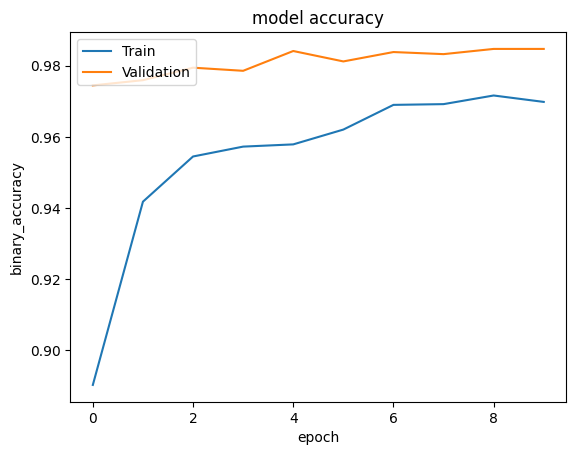

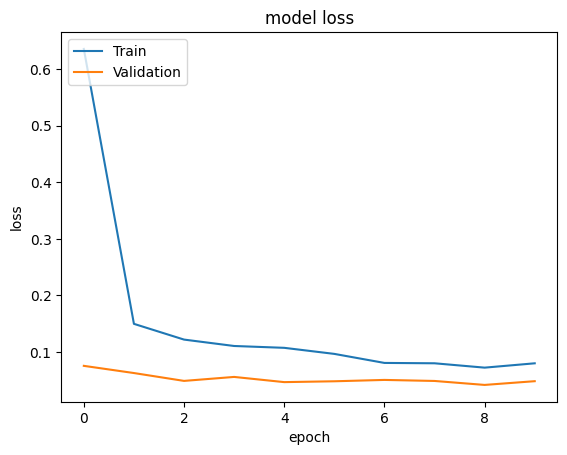

In [37]:
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title("model accuracy")
plt.ylabel('binary_accuracy')
plt.xlabel('epoch')
plt.legend(["Train", 'Validation'], loc='upper left')
plt.show()


plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel('epoch')
plt.legend(["Train", 'Validation'], loc='upper left')
plt.show()

Predict 

In [61]:
from tensorflow.keras.preprocessing import image

image_path='Dataset2/train/Jeruk Nipis/6a3809c9-790b-4df2-9dc1-ad133d93dc92.jpg'
img= image.load_img(image_path, target_size=(224,224))

#Convert image to numpy array
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = x/255.0 

#Predict
pred = model.predict(x)
labels = ['Belimbing Sayur', 'Bunga Lawang', 'Jahe', 'Jeruk Nipis', 'Kunyit', 'Lengkuas', 'Mengkudu']
for i, p in enumerate(pred[0]):
    if p>0.5:
        print(labels[i], p)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step
Jeruk Nipis 0.9999086


## Memprediksi 2 Bahan

In [64]:
import numpy as np
from tensorflow.keras.preprocessing import image

# Load image
image_path = 'jahe dan jeruk nipis.jpg'
img = image.load_img(image_path, target_size=(224, 224))

# Convert image to numpy array
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = x / 255.0 

# Predict
pred = model.predict(x)
labels = ['Belimbing Sayur', 'Bunga Lawang', 'Jahe', 'Jeruk Nipis', 'Kunyit', 'Lengkuas', 'Mengkudu']

# Get indices of top 2 predictions
top_2_indices = np.argsort(pred[0])[-2:]  # Ambil dua indeks tertinggi (urutkan dari kecil ke besar)
top_2_indices = top_2_indices[::-1]  # Balik urutan menjadi besar ke kecil

# Print top 2 predictions with their probabilities
for i in top_2_indices:
    print(f"{labels[i]}: {pred[0][i]:.2f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step
Jeruk Nipis: 0.99
Jahe: 0.00


In [66]:
import numpy as np
from tensorflow.keras.preprocessing import image

# Load image
image_path = 'jahe dan jeruk nipis2.jpg'
img = image.load_img(image_path, target_size=(224, 224))

# Convert image to numpy array
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = x / 255.0 

# Predict
pred = model.predict(x)
labels = ['Belimbing Sayur', 'Bunga Lawang', 'Jahe', 'Jeruk Nipis', 'Kunyit', 'Lengkuas', 'Mengkudu']

# Get indices of top 2 predictions
top_2_indices = np.argsort(pred[0])[-2:]  # Ambil dua indeks tertinggi (urutkan dari kecil ke besar)
top_2_indices = top_2_indices[::-1]  # Balik urutan menjadi besar ke kecil

# Print top 2 predictions with their probabilities
for i in top_2_indices:
    print(f"{labels[i]}: {pred[0][i]:.2f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
Jahe: 0.03
Jeruk Nipis: 0.01


## Memprediksi 3 Bahan

In [53]:
import numpy as np
from tensorflow.keras.preprocessing import image

# Load image
image_path = 'jeruk nipis dan bunga lawang.jpg'
img = image.load_img(image_path, target_size=(224, 224))

# Convert image to numpy array
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = x / 255.0 

# Predict
pred = model.predict(x)
labels = ['Belimbing Sayur', 'Bunga Lawang', 'Jahe', 'Jeruk Nipis', 'Kunyit', 'Lengkuas', 'Mengkudu']

# Get indices of top 2 predictions
top_2_indices = np.argsort(pred[0])[-3:]  # Ambil dua indeks tertinggi (urutkan dari kecil ke besar)
top_2_indices = top_2_indices[::-1]  # Balik urutan menjadi besar ke kecil

# Print top 2 predictions with their probabilities
for i in top_2_indices:
    print(f"{labels[i]}: {pred[0][i]:.2f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
Bunga Lawang: 0.35
Jahe: 0.14
Kunyit: 0.03


In [52]:
import numpy as np
from tensorflow.keras.preprocessing import image

# Load image
image_path = 'test1.jpg'
img = image.load_img(image_path, target_size=(224, 224))

# Convert image to numpy array
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = x / 255.0 

# Predict
pred = model.predict(x)
labels = ['Belimbing Sayur', 'Bunga Lawang', 'Jahe', 'Jeruk Nipis', 'Kunyit', 'Lengkuas', 'Mengkudu']

# Get indices of top 2 predictions
top_2_indices = np.argsort(pred[0])[-3:]  # Ambil dua indeks tertinggi (urutkan dari kecil ke besar)
top_2_indices = top_2_indices[::-1]  # Balik urutan menjadi besar ke kecil

# Print top 2 predictions with their probabilities
for i in top_2_indices:
    print(f"{labels[i]}: {pred[0][i]:.2f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step
Lengkuas: 0.56
Kunyit: 0.14
Jahe: 0.13


### Menggunakan Tracehold

In [78]:
import numpy as np
from tensorflow.keras.preprocessing import image

# Load image
image_path = '6a3809c9-790b-4df2-9dc1-ad133d93dc92.jpg'
img = image.load_img(image_path, target_size=(224, 224))

# Convert image to numpy array
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = x / 255.0 

# Predict
pred = model.predict(x)
labels = ['Belimbing Sayur', 'Bunga Lawang', 'Jahe', 'Jeruk Nipis', 'Kunyit', 'Lengkuas', 'Mengkudu']

# Set probability threshold
threshold = 0.1  # Probabilitas minimum untuk dianggap "terdeteksi"

# Filter predictions based on threshold
filtered_predictions = [(labels[i], prob) for i, prob in enumerate(pred[0]) if prob > threshold]

# Sort predictions by probability in descending order
filtered_predictions = sorted(filtered_predictions, key=lambda x: x[1], reverse=True)

# Print filtered predictions
if filtered_predictions:
    print("Detected items:")
    for label, prob in filtered_predictions:
        print(f"{label}: {prob:.2f}")
else:
    print("No items detected with the given threshold.")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step
Detected items:
Jeruk Nipis: 1.00


In [75]:
import numpy as np
from tensorflow.keras.preprocessing import image

# Load image
image_path = 'jahe dan lengkuas.jpg'
img = image.load_img(image_path, target_size=(224, 224))

# Convert image to numpy array
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = x / 255.0 

# Predict
pred = model.predict(x)  # Model harus sudah didefinisikan sebelumnya
labels = ['Belimbing Sayur', 'Bunga Lawang', 'Jahe', 'Jeruk Nipis', 'Kunyit', 'Lengkuas', 'Mengkudu']

# Debugging: Print probabilities for all labels
print("Probabilities for all labels:")
for label, prob in zip(labels, pred[0]):
    print(f"{label}: {prob:.2f}")

# Set probability threshold
threshold = 0.001  # Probabilitas minimum untuk dianggap "terdeteksi"

# Get labels with probabilities above the threshold
detected_labels = [(labels[i], prob) for i, prob in enumerate(pred[0]) if prob > threshold]

# Sort detected labels by probability in descending order
detected_labels = sorted(detected_labels, key=lambda x: x[1], reverse=True)

# Print detected labels with their probabilities
if detected_labels:
    print(f"\nDetected {len(detected_labels)} item(s):")
    for label, prob in detected_labels:
        print(f"{label}: {prob:.2f}")
else:
    print("\nNo items detected with the given threshold.")

# Recommendation: Adjust threshold if needed
if len(detected_labels) < 2:  # Contoh kondisi jika hanya 1 atau kurang yang terdeteksi
    print("\nConsider lowering the threshold for better detection results.")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
Probabilities for all labels:
Belimbing Sayur: 0.00
Bunga Lawang: 0.00
Jahe: 0.08
Jeruk Nipis: 0.00
Kunyit: 0.03
Lengkuas: 0.50
Mengkudu: 0.00

Detected 3 item(s):
Lengkuas: 0.50
Jahe: 0.08
Kunyit: 0.03
